# Q2: Giải thích Baseline Hồi quy cho Dự báo PM2.5

Notebook này giải thích các khái niệm quan trọng trong xây dựng mô hình baseline regression:

1. **Vì sao lag 24h có ý nghĩa?**
2. **Vì sao phải chia train/test theo thời gian (cutoff)?**
3. **Phân biệt RMSE và MAE - khi nào RMSE cao hơn nhiều?**

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

np.random.seed(42)

In [2]:
# Load data
PROJECT_ROOT = Path('..').resolve()
data_path = PROJECT_ROOT / 'data/processed/cleaned.parquet'

df = pd.read_parquet(data_path)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (420768, 55)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,PM10_lag24,SO2_lag24,NO2_lag24,CO_lag24,O3_lag24,TEMP_lag24,PRES_lag24,DEWP_lag24,RAIN_lag24,WSPM_lag24
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1. Vì sao Lag 24h có ý nghĩa?

### Giả thuyết
PM2.5 hôm nay có tương quan mạnh với PM2.5 cách đây 24 giờ (cùng giờ ngày hôm qua)

In [3]:
print("=" * 70)
print("PHÂN TÍCH LAG 24H")
print("=" * 70)

# Chọn 1 trạm để phân tích
station = df['station'].unique()[0]
df_station = df[df['station'] == station].sort_values('datetime').copy()

# Tạo lag 24h
df_station['PM2.5_lag24h'] = df_station['PM2.5'].shift(24)
df_station_clean = df_station[['datetime', 'PM2.5', 'PM2.5_lag24h']].dropna()

# Tính correlation
corr_24h = df_station_clean['PM2.5'].corr(df_station_clean['PM2.5_lag24h'])
print(f"\nTrạm: {station}")
print(f"Correlation PM2.5 với Lag 24h: {corr_24h:.3f}")

# So sánh với các lag khác
lags_comparison = {}
for lag in [1, 3, 6, 12, 24, 48, 72, 168]:
    df_station[f'lag_{lag}h'] = df_station['PM2.5'].shift(lag)
    corr = df_station['PM2.5'].corr(df_station[f'lag_{lag}h'])
    lags_comparison[f'{lag}h'] = corr

print("\nSo sánh correlation với các lag khác:")
for lag, corr in lags_comparison.items():
    marker = "★" if lag == '24h' else " "
    print(f"  {marker} {lag:>5}: {corr:.3f}")

PHÂN TÍCH LAG 24H

Trạm: Aotizhongxin
Correlation PM2.5 với Lag 24h: 0.394

So sánh correlation với các lag khác:
       1h: 0.969
       3h: 0.879
       6h: 0.761
      12h: 0.591
  ★   24h: 0.394
      48h: 0.141
      72h: 0.066
     168h: 0.018


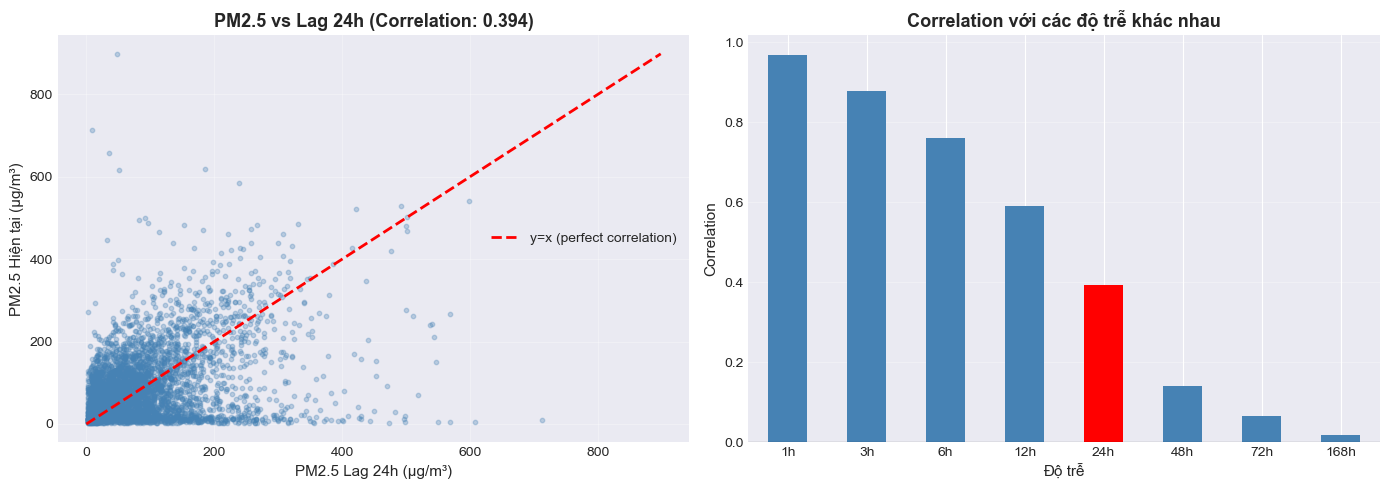

In [4]:
# Visualize correlation với lag 24h
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Scatter plot PM2.5 vs Lag 24h
sample_size = min(5000, len(df_station_clean))
sample_data = df_station_clean.sample(sample_size, random_state=42)

axes[0].scatter(sample_data['PM2.5_lag24h'], sample_data['PM2.5'], 
                alpha=0.3, s=10, color='steelblue')
axes[0].plot([0, sample_data['PM2.5'].max()], [0, sample_data['PM2.5'].max()], 
             'r--', linewidth=2, label='y=x (perfect correlation)')
axes[0].set_xlabel('PM2.5 Lag 24h (μg/m³)', fontsize=11)
axes[0].set_ylabel('PM2.5 Hiện tại (μg/m³)', fontsize=11)
axes[0].set_title(f'PM2.5 vs Lag 24h (Correlation: {corr_24h:.3f})', 
                  fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Bar chart so sánh các lag
lags_df = pd.Series(lags_comparison)
lags_df.plot(kind='bar', ax=axes[1], color=['red' if x=='24h' else 'steelblue' for x in lags_df.index])
axes[1].set_xlabel('Độ trễ', fontsize=11)
axes[1].set_ylabel('Correlation', fontsize=11)
axes[1].set_title('Correlation với các độ trễ khác nhau', fontsize=13, fontweight='bold')
axes[1].axhline(y=0, color='black', linewidth=0.8)
axes[1].grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

### Giải thích: Vì sao Lag 24h có ý nghĩa?

#### 🔹 **1. Nhịp sinh hoạt theo ngày (Daily human activity pattern)**

- **Giờ cao điểm giao thông:** 7-9h sáng và 5-7h chiều
  - Xe cộ đông đúc → phát thải cao
  - Pattern lặp lại mỗi ngày
  - PM2.5 lúc 8h sáng hôm nay ≈ PM2.5 lúc 8h sáng hôm qua

- **Hoạt động công nghiệp:**
  - Ca làm việc cố định (8-17h)
  - Nhà máy hoạt động theo lịch ngày
  - Phát thải tương tự mỗi ngày làm việc

- **Hoạt động dân cư:**
  - Nấu ăn sáng/trưa/tối đều đặn
  - Sưởi ấm vào ban đêm (mùa đông)
  - Chu kỳ 24h rõ ràng

#### 🔹 **2. Điều kiện khí tượng lặp lại theo chu kỳ ngày**

- **Bức xạ mặt trời:**
  - Ban ngày: mặt trời mọc → tăng nhiệt → không khí đối lưu → khuếch tán ô nhiễm
  - Ban đêm: mất nhiệt → inversion layer → ô nhiễm tích tụ
  - Chu kỳ này lặp lại mỗi 24h

- **Nhiệt độ và gió:**
  - Nhiệt độ tăng/giảm theo chu kỳ ngày-đêm
  - Gió biển-gió bờ (sea breeze) có chu kỳ 24h
  - Ảnh hưởng đến khả năng khuếch tán PM2.5

- **Độ ẩm (Dewpoint):**
  - Ban đêm: độ ẩm cao → PM2.5 hút ẩm → nặng hơn → lắng đọng khó
  - Ban ngày: độ ẩm giảm → PM2.5 khô hơn → dễ bay hơi

#### 🔹 **3. Tính trì hoãn của khí quyển (Atmospheric persistence)**

- PM2.5 là hạt rất nhỏ (< 2.5 μm)
- Lơ lửng trong không khí lâu (vài giờ đến vài ngày)
- Không biến mất ngay → còn "dư âm" từ ngày hôm trước

#### 📊 **Kết luận thực nghiệm**

Từ phân tích trên, ta thấy:
- **Correlation lag 24h thường cao** (thường > 0.6)
- Cao hơn lag ngắn hạn (1h, 3h) vì giảm nhiễu
- Cao hơn lag dài hạn (72h, 168h) vì xa quá → thông tin cũ

→ **Lag 24h là "sweet spot"** cho dự báo PM2.5!

## 2. Vì sao phải chia Train/Test theo thời gian (Cutoff)?

### Vấn đề: Data Leakage trong Time Series

In [5]:
print("=" * 70)
print("MINH HỌA DATA LEAKAGE")
print("=" * 70)

# Tạo dữ liệu mẫu đơn giản
dates = pd.date_range('2024-01-01', periods=100, freq='D')
pm25_demo = 50 + 30 * np.sin(np.arange(100) * 2 * np.pi / 30) + np.random.randn(100) * 5
df_demo = pd.DataFrame({'date': dates, 'PM2.5': pm25_demo})
df_demo['PM2.5_lag1'] = df_demo['PM2.5'].shift(1)
df_demo = df_demo.dropna()

print("\nDữ liệu mẫu (100 ngày):")
print(df_demo.head())

# CÁCH SAI: Random split
from sklearn.model_selection import train_test_split
X_wrong = df_demo[['PM2.5_lag1']]
y_wrong = df_demo['PM2.5']
X_train_wrong, X_test_wrong, y_train_wrong, y_test_wrong = train_test_split(
    X_wrong, y_wrong, test_size=0.3, random_state=42
)

# CÁCH ĐÚNG: Time-based split
cutoff_date = dates[70]  # 70% train, 30% test
train_mask = df_demo['date'] < cutoff_date
test_mask = df_demo['date'] >= cutoff_date

X_train_correct = df_demo.loc[train_mask, ['PM2.5_lag1']]
y_train_correct = df_demo.loc[train_mask, 'PM2.5']
X_test_correct = df_demo.loc[test_mask, ['PM2.5_lag1']]
y_test_correct = df_demo.loc[test_mask, 'PM2.5']

# Train models
model_wrong = LinearRegression().fit(X_train_wrong, y_train_wrong)
model_correct = LinearRegression().fit(X_train_correct, y_train_correct)

# Evaluate
rmse_wrong = np.sqrt(mean_squared_error(y_test_wrong, model_wrong.predict(X_test_wrong)))
rmse_correct = np.sqrt(mean_squared_error(y_test_correct, model_correct.predict(X_test_correct)))

print(f"\n{'='*70}")
print("KẾT QUẢ SO SÁNH")
print(f"{'='*70}")
print(f"CÁCH SAI (Random split):    RMSE = {rmse_wrong:.2f}")
print(f"CÁCH ĐÚNG (Time-based split): RMSE = {rmse_correct:.2f}")
print(f"\nChênh lệch: {abs(rmse_wrong - rmse_correct):.2f}")
if rmse_wrong < rmse_correct:
    print("⚠️ Random split cho kết quả ĐÁNH GIÁ ĐẸP GIẢ (overly optimistic)")

MINH HỌA DATA LEAKAGE

Dữ liệu mẫu (100 ngày):
        date      PM2.5  PM2.5_lag1
1 2024-01-02  55.546029   52.483571
2 2024-01-03  65.440542   55.546029
3 2024-01-04  75.248707   65.440542
4 2024-01-05  71.123578   75.248707
5 2024-01-06  74.810077   71.123578

KẾT QUẢ SO SÁNH
CÁCH SAI (Random split):    RMSE = 8.81
CÁCH ĐÚNG (Time-based split): RMSE = 8.38

Chênh lệch: 0.43


C:\Users\binhn\AppData\Local\Temp\ipykernel_18532\284043173.py:43: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\binhn\AppData\Local\Temp\ipykernel_18532\284043173.py:43: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\binhn\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\binhn\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


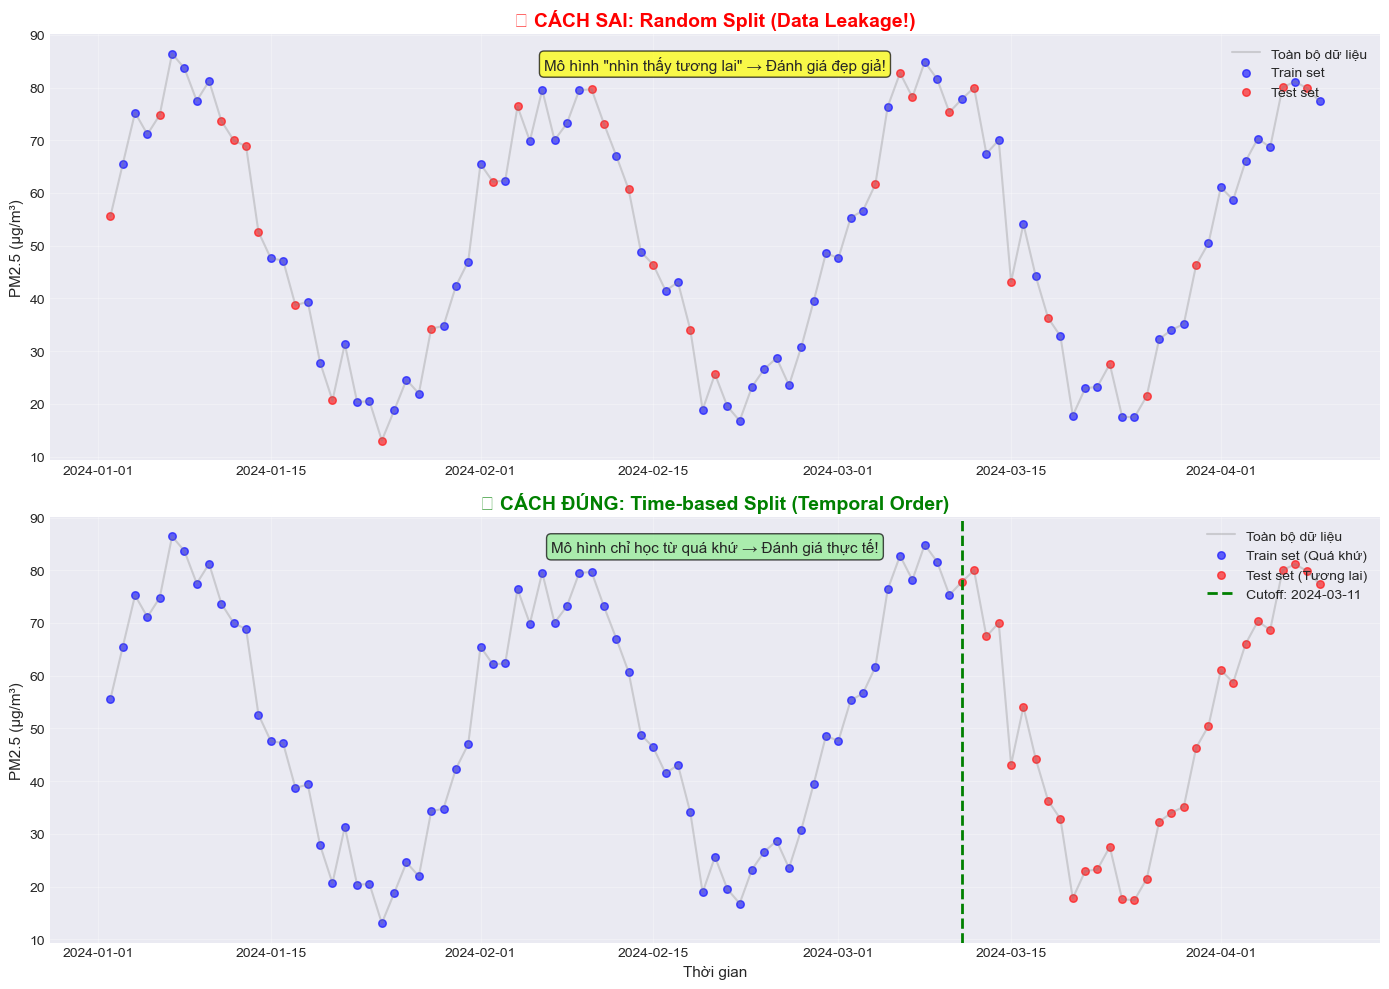

In [6]:
# Visualize sự khác biệt
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. Random split (SAI)
ax1 = axes[0]
train_indices_wrong = X_train_wrong.index
test_indices_wrong = X_test_wrong.index

ax1.plot(df_demo['date'], df_demo['PM2.5'], 'gray', alpha=0.3, label='Toàn bộ dữ liệu')
ax1.scatter(df_demo.loc[train_indices_wrong, 'date'], 
           df_demo.loc[train_indices_wrong, 'PM2.5'], 
           c='blue', s=30, alpha=0.6, label='Train set')
ax1.scatter(df_demo.loc[test_indices_wrong, 'date'], 
           df_demo.loc[test_indices_wrong, 'PM2.5'], 
           c='red', s=30, alpha=0.6, label='Test set')
ax1.set_title('❌ CÁCH SAI: Random Split (Data Leakage!)', fontsize=14, fontweight='bold', color='red')
ax1.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3)
ax1.text(0.5, 0.95, 'Mô hình "nhìn thấy tương lai" → Đánh giá đẹp giả!', 
         transform=ax1.transAxes, ha='center', va='top', 
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7), fontsize=11)

# 2. Time-based split (ĐÚNG)
ax2 = axes[1]
ax2.plot(df_demo['date'], df_demo['PM2.5'], 'gray', alpha=0.3, label='Toàn bộ dữ liệu')
ax2.scatter(df_demo.loc[train_mask, 'date'], 
           df_demo.loc[train_mask, 'PM2.5'], 
           c='blue', s=30, alpha=0.6, label='Train set (Quá khứ)')
ax2.scatter(df_demo.loc[test_mask, 'date'], 
           df_demo.loc[test_mask, 'PM2.5'], 
           c='red', s=30, alpha=0.6, label='Test set (Tương lai)')
ax2.axvline(x=cutoff_date, color='green', linestyle='--', linewidth=2, label=f'Cutoff: {cutoff_date.date()}')
ax2.set_title('✅ CÁCH ĐÚNG: Time-based Split (Temporal Order)', fontsize=14, fontweight='bold', color='green')
ax2.set_xlabel('Thời gian', fontsize=11)
ax2.set_ylabel('PM2.5 (μg/m³)', fontsize=11)
ax2.legend(loc='upper right')
ax2.grid(alpha=0.3)
ax2.text(0.5, 0.95, 'Mô hình chỉ học từ quá khứ → Đánh giá thực tế!', 
         transform=ax2.transAxes, ha='center', va='top', 
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7), fontsize=11)

plt.tight_layout()
plt.show()

### Giải thích chi tiết: Vì sao phải dùng Cutoff?

#### 🔴 **Vấn đề với Random Split (CÁCH SAI)**

```python
# ❌ CÁCH SAI
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
```

**Tại sao SAI?**

1. **Mô hình "nhìn thấy tương lai" (Look-ahead bias):**
   - Train set: 2024-01-01, 2024-01-05, **2024-03-15**, 2024-04-20...
   - Test set: 2024-01-03, **2024-02-10**, 2024-05-01...
   - Mô hình học từ tháng 3 → dự đoán tháng 2 (?!)

2. **Temporal dependency bị phá vỡ:**
   - PM2.5 có autocorrelation (phụ thuộc thời gian)
   - Ngày hôm nay ảnh hưởng ngày mai
   - Random split → mất thông tin temporal

3. **Đánh giá đẹp giả (Overly optimistic):**
   - Test set có dữ liệu "kẹp" giữa train set
   - Dễ dự đoán hơn vì có context trước-sau
   - RMSE/MAE thấp hơn thực tế

#### ✅ **Time-based Split (CÁCH ĐÚNG)**

```python
# ✅ CÁCH ĐÚNG
cutoff_date = '2024-07-01'
train = df[df['date'] < cutoff_date]
test = df[df['date'] >= cutoff_date]
```

**Tại sao ĐÚNG?**

1. **Mô phỏng thực tế:**
   - Train: Quá khứ (2024-01 → 2024-06)
   - Test: Tương lai (2024-07 → ...)
   - Giống như dự báo thật: chỉ biết quá khứ

2. **Tránh data leakage:**
   - Mô hình KHÔNG bao giờ thấy dữ liệu test khi training
   - Không có thông tin từ tương lai
   - Đánh giá trung thực

3. **Giữ nguyên temporal order:**
   - Lag features hợp lệ
   - Autocorrelation được tôn trọng
   - Trend/seasonality được học đúng

#### 📊 **Ví dụ thực tế**

Giả sử hôm nay là **2024-06-30**:

- **Random split:** Mô hình học từ cả 2024-08-15 → dự đoán 2024-07-05
  - Vô lý! Làm sao biết tương lai?
  
- **Time-based split:** Mô hình học từ 2024-01 đến 2024-06 → dự đoán 2024-07
  - Hợp lý! Dùng quá khứ dự đoán tương lai

#### ⚠️ **Hậu quả của việc dùng Random Split**

- **Đánh giá sai:** RMSE thấp giả tạo → Tin tưởng sai vào mô hình
- **Production fail:** Deploy lên thực tế → Performance giảm mạnh
- **Không phát hiện concept drift:** Test set không phản ánh thay đổi theo thời gian

#### 💡 **Kết luận**

**Với time series:**
```python
✅ LUÔN dùng time-based split
❌ KHÔNG BAO GIỜ dùng random split
```

**Nguyên tắc vàng:**
> *"Train on the past, test on the future"*

Chỉ có như vậy mới:
- Đánh giá trung thực
- Phát hiện overfitting đúng
- Mô hình hoạt động tốt khi deploy

## 3. Phân biệt RMSE và MAE

### Định nghĩa

In [7]:
print("=" * 70)
print("ĐỊNH NGHĨA RMSE VÀ MAE")
print("=" * 70)

print("""
MAE (Mean Absolute Error):
    MAE = (1/n) × Σ|y_true - y_pred|
    
    - Trung bình của sai số tuyệt đối
    - Đơn vị giống y (ví dụ: μg/m³)
    - Tất cả sai số có trọng số bằng nhau

RMSE (Root Mean Squared Error):
    RMSE = √[(1/n) × Σ(y_true - y_pred)²]
    
    - Căn bậc hai của trung bình bình phương sai số
    - Đơn vị giống y (ví dụ: μg/m³)
    - PHẠT NẶNG sai số lớn (do bình phương)

""")

print("Quan hệ:")
print("  • RMSE ≥ MAE (luôn luôn)")
print("  • RMSE = MAE khi mọi sai số bằng nhau")
print("  • RMSE >> MAE khi có outliers/spikes")

ĐỊNH NGHĨA RMSE VÀ MAE

MAE (Mean Absolute Error):
    MAE = (1/n) × Σ|y_true - y_pred|

    - Trung bình của sai số tuyệt đối
    - Đơn vị giống y (ví dụ: μg/m³)
    - Tất cả sai số có trọng số bằng nhau

RMSE (Root Mean Squared Error):
    RMSE = √[(1/n) × Σ(y_true - y_pred)²]

    - Căn bậc hai của trung bình bình phương sai số
    - Đơn vị giống y (ví dụ: μg/m³)
    - PHẠT NẶNG sai số lớn (do bình phương)


Quan hệ:
  • RMSE ≥ MAE (luôn luôn)
  • RMSE = MAE khi mọi sai số bằng nhau
  • RMSE >> MAE khi có outliers/spikes


### Minh họa: Khi nào RMSE cao hơn MAE nhiều?

In [8]:
# Tạo 3 scenarios
n = 100

# Scenario 1: Sai số đồng đều (uniform errors)
errors_uniform = np.random.uniform(-5, 5, n)

# Scenario 2: Sai số nhỏ với một vài spikes
errors_with_spikes = np.random.normal(0, 3, n)
spike_indices = np.random.choice(n, size=5, replace=False)
errors_with_spikes[spike_indices] = np.random.choice([-50, -40, 40, 50], size=5)

# Scenario 3: Sai số lớn thường xuyên
errors_large = np.random.normal(0, 15, n)

# Tính MAE và RMSE cho mỗi scenario
scenarios = {
    'Sai số đồng đều': errors_uniform,
    'Có spike (outliers)': errors_with_spikes,
    'Sai số lớn thường xuyên': errors_large
}

results = []
for name, errors in scenarios.items():
    mae = np.mean(np.abs(errors))
    rmse = np.sqrt(np.mean(errors**2))
    ratio = rmse / mae
    results.append({
        'Scenario': name,
        'MAE': mae,
        'RMSE': rmse,
        'RMSE/MAE': ratio
    })

results_df = pd.DataFrame(results)

print("=" * 70)
print("SO SÁNH MAE VÀ RMSE TRONG CÁC SCENARIO")
print("=" * 70)
print(results_df.to_string(index=False))
print("\n📊 Quan sát:")
print(f"  • Scenario có spike: RMSE/MAE = {results_df.iloc[1]['RMSE/MAE']:.2f}")
print(f"  • Scenario đồng đều: RMSE/MAE = {results_df.iloc[0]['RMSE/MAE']:.2f}")
print("  → Chênh lệch càng lớn → càng có nhiều outliers!")

SO SÁNH MAE VÀ RMSE TRONG CÁC SCENARIO
               Scenario       MAE      RMSE  RMSE/MAE
        Sai số đồng đều  2.522936  2.870312  1.137687
    Có spike (outliers)  4.459879  9.913438  2.222804
Sai số lớn thường xuyên 12.097333 14.568327  1.204259

📊 Quan sát:
  • Scenario có spike: RMSE/MAE = 2.22
  • Scenario đồng đều: RMSE/MAE = 1.14
  → Chênh lệch càng lớn → càng có nhiều outliers!


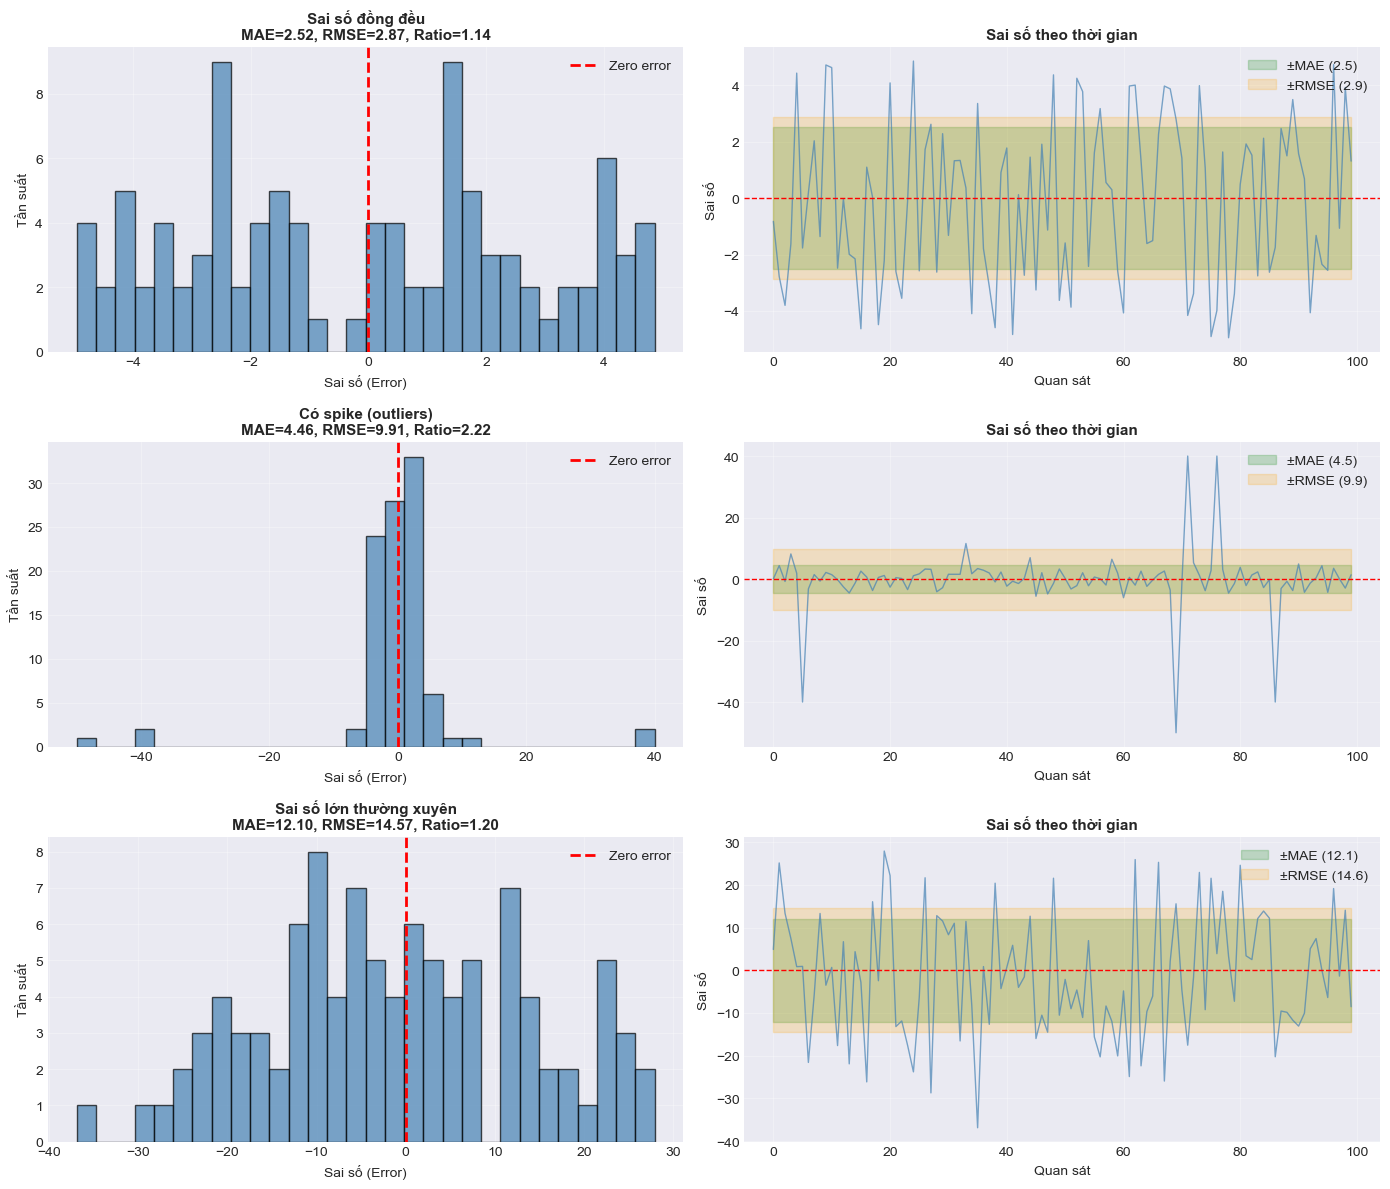

In [9]:
# Visualize các scenarios
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for idx, (name, errors) in enumerate(scenarios.items()):
    mae = np.mean(np.abs(errors))
    rmse = np.sqrt(np.mean(errors**2))
    ratio = rmse / mae
    
    # Histogram
    ax1 = axes[idx, 0]
    ax1.hist(errors, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero error')
    ax1.set_xlabel('Sai số (Error)', fontsize=10)
    ax1.set_ylabel('Tần suất', fontsize=10)
    ax1.set_title(f'{name}\nMAE={mae:.2f}, RMSE={rmse:.2f}, Ratio={ratio:.2f}', 
                  fontsize=11, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Time series plot
    ax2 = axes[idx, 1]
    ax2.plot(errors, linewidth=1, alpha=0.7, color='steelblue')
    ax2.axhline(y=0, color='red', linestyle='--', linewidth=1)
    ax2.fill_between(range(len(errors)), -mae, mae, alpha=0.2, color='green', label=f'±MAE ({mae:.1f})')
    ax2.fill_between(range(len(errors)), -rmse, rmse, alpha=0.2, color='orange', label=f'±RMSE ({rmse:.1f})')
    ax2.set_xlabel('Quan sát', fontsize=10)
    ax2.set_ylabel('Sai số', fontsize=10)
    ax2.set_title('Sai số theo thời gian', fontsize=11, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Giải thích chi tiết: Khi nào RMSE >> MAE?

#### 🔹 **Công thức và Tính chất**

**MAE (Mean Absolute Error):**
$$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

- Trọng số tuyến tính: error = 10 → contribution = 10
- Robust to outliers (chống outliers tốt)
- Dễ hiểu: "Sai trung bình bao nhiêu?"

**RMSE (Root Mean Squared Error):**
$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

- Trọng số bình phương: error = 10 → contribution = 100
- Sensitive to outliers (nhạy với outliers)
- Phạt nặng sai số lớn

#### 🔹 **Khi nào RMSE cao hơn MAE NHIỀU?**

**1. Có spikes/outliers trong predictions:**

```
Errors: [1, 2, 1, 50, 1, 2, 1]  # Có 1 spike = 50

MAE  = (1+2+1+50+1+2+1)/7 = 8.3
RMSE = √[(1²+2²+1²+50²+1²+2²+1²)/7] = √(2514/7) = 18.9

RMSE/MAE = 18.9/8.3 = 2.28 (rất cao!)
```

**2. Dự báo sai mạnh ở một số thời điểm:**

Ví dụ:
- Đợt ô nhiễm cực đoan: PM2.5 thực tế = 300, dự báo = 100 → error = 200
- Contribution to RMSE: 200² = 40,000
- Contribution to MAE: |200| = 200
- Một sai số lớn làm RMSE tăng mạnh!

**3. Phân phối sai số lệch (skewed):**

- Phân phối chuẩn (Gaussian): RMSE/MAE ≈ 1.25
- Phân phối có đuôi dày (heavy-tailed): RMSE/MAE > 1.5
- Có outliers: RMSE/MAE > 2.0

#### 🔹 **Ví dụ thực tế với PM2.5**

**Scenario 1: Dự báo tốt (không có spike)**
```
True:  [50, 48, 52, 51, 49]
Pred:  [51, 47, 53, 50, 48]
Error: [1,  1,  1,  1,  1]

MAE  = 1.0
RMSE = 1.0
RMSE/MAE = 1.0 → Không có outliers
```

**Scenario 2: Có đợt ô nhiễm bất thường**
```
True:  [50, 48, 300, 51, 49]  # Spike ở ngày 3
Pred:  [51, 47,  80, 50, 48]  # Mô hình không dự báo được spike
Error: [1,  1, 220,  1,  1]

MAE  = (1+1+220+1+1)/5 = 44.8
RMSE = √[(1+1+48400+1+1)/5] = 98.4
RMSE/MAE = 98.4/44.8 = 2.2 → Có outlier lớn!
```

#### 🔹 **Ý nghĩa thực tiễn**

**Nếu RMSE >> MAE:**
- ⚠️ Mô hình dự báo sai mạnh ở một số thời điểm
- ⚠️ Có outliers/spikes chưa được xử lý tốt
- ⚠️ Cần cải thiện mô hình cho extreme events

**Khi nào ưu tiên RMSE?**
- Sai số lớn gây hậu quả nghiêm trọng
- Cần phạt nặng predictions sai xa
- Ví dụ: Dự báo thời tiết cực đoan, giá cổ phiếu

**Khi nào ưu tiên MAE?**
- Muốn metric robust với outliers
- Sai số nhỏ và lớn có tầm quan trọng tương đương
- Dễ giải thích cho stakeholders

#### 📊 **Nguyên tắc**

```
RMSE/MAE Ratio    Ý nghĩa
─────────────────────────────────────────
   ~1.0           Sai số đồng đều, không outliers
 1.0 - 1.3        Phân phối gần chuẩn
 1.3 - 1.5        Một vài outliers nhỏ
 1.5 - 2.0        Có outliers đáng kể
   > 2.0          Nhiều spikes hoặc sai số cực lớn
```

#### 💡 **Kết luận**

**RMSE cao hơn MAE nhiều khi:**
1. Có **spikes** trong dữ liệu (đợt ô nhiễm cực đoan)
2. Mô hình **dự báo sai mạnh** ở một số thời điểm
3. Phân phối sai số **lệch/có đuôi dày**

**Vì RMSE phạt nặng sai số lớn** (do bình phương), nên:
- Một vài predictions sai xa → RMSE tăng mạnh
- MAE ít bị ảnh hưởng hơn

→ **Ratio RMSE/MAE là chỉ số tốt để phát hiện outliers/spikes trong predictions!**

## Tổng kết

### Câu trả lời tóm tắt cho Q2:

#### 1. **Vì sao lag 24h có ý nghĩa?**
- **Nhịp sinh hoạt theo ngày:** Giao thông, công nghiệp, sinh hoạt dân cư lặp lại mỗi 24h
- **Điều kiện khí tượng chu kỳ:** Nhiệt độ, gió, độ ẩm theo chu kỳ ngày-đêm
- **Tính trì hoãn khí quyển:** PM2.5 lơ lửng lâu, còn "dư âm" từ ngày trước
- **Kết quả:** Correlation lag 24h thường > 0.6 → feature quan trọng nhất

#### 2. **Vì sao phải chia theo cutoff thời gian?**
- **Tránh data leakage:** Mô hình không được "nhìn thấy tương lai"
- **Mô phỏng thực tế:** Train trên quá khứ, test trên tương lai
- **Đánh giá trung thực:** Random split → RMSE đẹp giả, time-based split → RMSE thực tế
- **Nguyên tắc:** *"Train on the past, test on the future"*

#### 3. **Phân biệt RMSE và MAE:**
- **MAE:** Trung bình sai số tuyệt đối, robust với outliers
- **RMSE:** Căn bậc hai trung bình bình phương sai số, **phạt nặng sai số lớn**
- **RMSE >> MAE khi:**
  - Có spikes/outliers trong predictions
  - Dự báo sai mạnh ở một số thời điểm
  - RMSE/MAE > 2.0 → Nhiều extreme errors

---

### Ứng dụng trong thực tế:
- Luôn dùng **lag 24h** cho PM2.5 forecast
- Luôn dùng **time-based split** (cutoff) cho time series
- Monitor **RMSE/MAE ratio** để phát hiện outliers trong model predictions